# 1. Download data & unzip

# 2. Importing Libraries & define function

In [ ]:
# ! pip install opencv-python

In [6]:
! pip install -I pip setuptools wheel
! pip install -I spacy
! python -m spacy download en_core_web_lg

Defaulting to user installation because normal site-packages is not writeable
  Using cached pip-22.1.2-py3-none-any.whl (2.1 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 7.3 MB/s eta 0:00:00a 0:00:01
  Using cached wheel-0.37.1-py2.py3-none-any.whl (35 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
launchpadlib 1.10.13 requires testresources, which is not installed.
alibi 0.6.5 requires scikit-learn<1.1.0,>=0.20.2, but you have scikit-learn 1.1.1 which is incompatible.
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 10.5 MB/s eta 0:00:0000:0100:01
  Using cached wasabi-0.9.1-py3-none-any.whl (26 kB)
  Using cached Jinja2-3.1.2-py3-none-any.whl (133 kB)
  Using cached requests-2.28.1-py3-none-any.whl (62 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130

In [2]:
import datetime
import sys

print(f"UTC now= '{datetime.datetime.utcnow().isoformat().split('.')[0]}'")
print(f'Virtualenv used: {sys.executable}')

import importlib


import pandas as pd
import pickle

from pathlib import Path

#for text pre-processing
import re, string

from sklearn.decomposition import TruncatedSVD
# bag of words
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix,roc_curve,auc
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import seaborn as sns

from sklearn import tree

from sentence_transformers import SentenceTransformer
sentence_bert_model = SentenceTransformer('distiluse-base-multilingual-cased-v1')

import spacy
importlib.reload(spacy)
spacy_nlp_model = spacy.load('en_core_web_lg')

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Initialize the lemmatizer
wl = WordNetLemmatizer()

from nltk.corpus import wordnet, stopwords

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# for LIME import necessary packages
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline

from typing import List, Optional, Union, Tuple

UTC now= '2022-07-20T12:26:03'
Virtualenv used: /usr/bin/python3


2022-07-20 14:26:05.630837: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-20 14:26:05.645230: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.0/lib64:
2022-07-20 14:26:05.648495: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/mmozolewski/.local/lib/python3.8/site-packages/spacy/util.py:865: UserWarning: [W095] Model 'en_core_web

In [3]:
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import cv2
import os, glob, shutil


In [4]:
def _save_pickle(df, outfile, results_folder):
  if results_folder:
    results_folder_local = f"{str(Path('~').expanduser().resolve())}/{results_folder}"
    # results_folder_local = results_folder
  else:
    results_folder_local = f"{str(Path('~').expanduser().resolve())}/data"
  Path(results_folder_local).mkdir(parents=True, exist_ok=True)
  fname = f"{results_folder_local}/{outfile}.pickle"
  print(fname)
  with open(fname, 'wb') as f:
    pickle.dump(df, f)


def _read_pandas_pickle(infile, data_folder):
  fname = f'{data_folder}/{infile}.pickle'
  return pd.read_pickle(fname)


def get_LSA(df:pd.DataFrame, column_to_omit:str, how_many_dimension:int, random_subsample:Optional[float]) -> Optional[pd.DataFrame]:
    svd = TruncatedSVD(how_many_dimension)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)
    if random_subsample:
      _df = df.sample(frac=random_subsample)
      print(f"using {len(_df.index)} observations")
      lsa.fit(_df.loc[:, df.columns != column_to_omit])
    else:
      lsa.fit(df.loc[:, df.columns != column_to_omit])
    print(f"explained variance perc = {svd.explained_variance_ratio_.sum()*100}%")

    chunk_size = 1_000
    rows_count = len(df.index)
    chunks = list()
    num_chunks = rows_count // chunk_size + 1
    for i in range(num_chunks):
      print(f"processing chunk {str(i)} of {str(num_chunks)}")
      chunks.append(pd.DataFrame(lsa.transform(df.loc[i*chunk_size : min(rows_count-1, (i+1)*chunk_size-1), df.columns != column_to_omit])))
    _df_lsa = pd.concat(chunks, axis=0)

    _df_lsa = _df_lsa.reset_index()
    del _df_lsa['index']

    _df_lsa[column_to_omit] = df[column_to_omit]
    return _df_lsa


def get_TSNE_and_PCA_embeddings(df:pd.DataFrame, key:str, random_subsample:Optional[float], incl_pca:bool = True):
  if random_subsample:
    _df = df.sample(frac=random_subsample)
    _df.reset_index(inplace=True)
    del _df['index']
    print(f"using {len(_df.index)} observations")
    df_independent_vars = _df.loc[:, (df.columns != key) & (df.columns != 'cluster_kmeans')]
  else:
    _df = df
    df_independent_vars = df.loc[:, (df.columns != key) & (df.columns != 'cluster_kmeans')]

  df_tsne = pd.DataFrame(TSNE(n_components=2).fit_transform(df_independent_vars))
  df_tsne['cluster'] = _df['cluster_kmeans']
  df_tsne.columns = ['x1', 'x2', 'cluster']
  df_tsne[key] = _df[key]

  df_tsne[['x1', 'x2']] = MinMaxScaler().fit_transform(df_tsne[['x1', 'x2']])

  if incl_pca:
    df_pca = pd.DataFrame(PCA(n_components=2).fit_transform(df_independent_vars))
    df_pca['cluster'] = _df['cluster_kmeans']
    df_pca.columns = ['x1', 'x2', 'cluster']
    df_pca[key] = _df[key]

    df_pca[['x1', 'x2']] = MinMaxScaler().fit_transform(df_pca[['x1', 'x2']])
  else:
    df_pca = None

  return df_tsne, df_pca


def k_means(df, column_to_omit, how_many_clusters):
  kmeans = KMeans(n_clusters=how_many_clusters, random_state=2022).fit(df.loc[:, (df.columns != column_to_omit) & (df.columns != 'cluster_kmeans')])
  df['cluster_kmeans'] = kmeans.labels_
  df['cluster_kmeans'] = df['cluster_kmeans'].astype(int)
  return df


def get_image_path(id:Union[int, str]):
  return 'notebooks/xai-survey/images/' + str(id) + '.jpg'

#### Plotting image from each cluster
def plot_example(df_with_cluster_kmeans_column:pd.DataFrame, cluster:Union[int, str], examples_count:int, axs):
  xyz = df_with_cluster_kmeans_column.loc[
    df_with_cluster_kmeans_column['cluster_kmeans'].apply(lambda x: str(x) == str(cluster)), 'id'].sample(n=examples_count).apply(lambda x: get_image_path(x)).tolist()
  img = [cv2.imread(abc,0) for abc in xyz]
  #print("Cluster No "+str(i))
  for j in range(min(examples_count, len(img))):
    try:
      axs[cluster][j].imshow(img[j], cmap = 'gray', interpolation = 'bicubic')
      axs[cluster][j].set_xticks([])
      axs[cluster][j].set_yticks([])
    except:
      axs[j].imshow(img[j], cmap = 'gray', interpolation = 'bicubic')
      axs[j].set_xticks([])
      axs[j].set_yticks([])


def plot_examples(df_with_cluster_kmeans_column:pd.DataFrame, examples_count:int):
  n_clusters = len(df_with_cluster_kmeans_column['cluster_kmeans'].unique())
  fig, axs = plt.subplots(n_clusters, examples_count, figsize=(50, 50)) ### making subplot
  for cluster in range(n_clusters):
    plot_example(df_with_cluster_kmeans_column, cluster, examples_count, axs)

In [5]:
#convert to lowercase, strip and remove punctuations
def preprocess(text, stopwords_list):
  text = text.lower()
  text = text.strip()
  text = re.compile('<.*?>').sub('', text)
  text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)
  text = re.sub('\s+', ' ', text)
  text = re.sub(r'\[[0-9]*\]', ' ', text)
  text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
  text = re.sub(r'\d', ' ', text)
  text = re.sub(r'\s+', ' ', text)
  text = ' '.join([i for i in text.split() if i not in list(stopwords_list)])
  return text


#LEMMATIZATION
# function to map NTLK position tags
def get_wordnet_pos(tag):
  if tag.startswith('J'):
    return wordnet.ADJ
  elif tag.startswith('V'):
    return wordnet.VERB
  elif tag.startswith('N'):
    return wordnet.NOUN
  elif tag.startswith('R'):
    return wordnet.ADV
  else:
    return wordnet.NOUN


# Tokenize the sentence
def lemmatizer(string):
  word_pos_tags = nltk.pos_tag(word_tokenize(string))  # Get position tags
  a = [wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)]  # Map the position tag and lemmatize the word/token
  return " ".join(a)


def finalpreprocess(text, stopwords_list):
  return lemmatizer(preprocess(text, stopwords_list))


def make_include_list(df:pd.DataFrame, columns: List[str]):
  words_to_include =[]
  for column in columns:
    words_to_include += df[column].unique().tolist()
  return list(set(words_to_include))


def get_observation_info(df:pd.DataFrame, key:str, column_year:Optional[Union[str, int]], column_txt:str):
  def wrap_by_word(s, n):
    '''returns a string where \\n is inserted between every n words'''
    if isinstance(s, str):
      a = s.split()
      ret = ''
      for i in range(0, len(a), n):
        ret += ' '.join(a[i:i+n]) + '\n'

      return ret
    return ""

  if column_year:
    return df[key] + " (" + df[column_year].apply(lambda x: str(int(x)) if isinstance(x, int) or isinstance(x, str) else "") + ") " + ": \n" + df[column_txt].apply(lambda x: wrap_by_word(x, 3))
  else:
    return df[key] + ": \n" + df[column_txt].apply(lambda x: wrap_by_word(x, 3))


def label_point(x, y, val, ax, factor):
  a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
  for i, point in a.iterrows():
    ax.text(point['x'] + 1*factor, point['y'] - 10*factor, str(point['val']))


def visualise_clusters(df_2d_embedding, key:str, column_year:Optional[Union[str, int]], column_txt:str, random_subsample:Optional[float], factor=1 / 200, base_size=6):
  _fig, _ax = plt.subplots(1, 1, figsize=(base_size*4,base_size*2))
  if random_subsample:
    df_for_plot = df_2d_embedding.sample(frac=random_subsample)
  else:
    df_for_plot = df_2d_embedding
  df_for_plot['cluster'] = df_for_plot['cluster_kmeans'].astype(int)
  sns.scatterplot(data=df_for_plot, x='x1', y='x2', hue='cluster', style='cluster', legend="full", alpha=0.9, s=120, palette="deep", ax=_ax)
  label_point(df_for_plot['x1'], df_for_plot['x2'], get_observation_info(df_for_plot, key, column_year, column_txt), _ax, factor)


# 2b. Class for augmenting clustering

In [6]:
class Pipeline:

  def __init__(self, df: pd.DataFrame, key: str):
    self.df = df
    self.df.reset_index(inplace=True)
    del self.df['index']
    self.key = key
    self.silhouette_scores:Optional[List[Tuple[int, float]]] = None
    self.column_year = None
    self.column_txt = None
    self.clusters_count:Optional[int] = None
    self.df_tsne:Optional[pd.DataFrame] = None
    self.df_pca:Optional[pd.DataFrame] = None
    self.text_column:Optional[str] = None
    self.clf = None
    self.df_metadata: Optional[pd.DataFrame] = None
    self.explainer:  Optional[LimeTextExplainer] = None
    self.c = None
    self.stop_words = None
    self.words_to_include = None
    self.clusters:Optional[List[int]] = None

    self.df['cluster_kmeans'] = np.NaN
    df_tsne, _ = get_TSNE_and_PCA_embeddings(self.df, self.key, .30, False)

    fig, ax = plt.subplots(1, 1, figsize=(12 * 1, 5 * 2))
    ax.set_title('TSNE')
    sns.scatterplot(data=df_tsne, x='x1', y='x2', hue='cluster', style='cluster', legend="full", alpha=0.9, palette="deep", s=100, ax=ax)
    # ax[1].set_title('PCA')
    # sns.scatterplot(data=self.df_pca, x='x1', y='x2', hue='cluster', style='cluster', legend="full", alpha=0.9, palette="deep", s=100, ax=ax[1])

  def plot_silhouette(self, max_clusters_count:int, random_subsample:Optional[float], reset:bool=False, show_on:Optional[List[int]]=None, size:float=2):
    if reset or not self.silhouette_scores:
      self.silhouette_scores = []
      # sil = []
      # kl = []
      for k in range(2, max_clusters_count + 1):
        df_subsample = self.df.loc[:, (self.df.columns != self.key) & (self.df.columns != 'cluster_kmeans')]
        if random_subsample:
          df_subsample = df_subsample.sample(frac=random_subsample)
        print(f"processing {k} clusters")
        kmeans2 = KMeans(n_clusters = k).fit(df_subsample)
        labels = kmeans2.labels_
        self.silhouette_scores.append((k, silhouette_score(df_subsample, labels)))
        # sil.append()
        # kl.append(k)

    kl = [x[0] for x in self.silhouette_scores]
    sil = [x[1] for x in self.silhouette_scores]
    plt.figure(figsize=(size*16, size*8))
    plt.plot(kl, sil)
    plt.ylabel('Silhouette Score')
    plt.ylabel('Clusters count')
    # self.silhouette_scores = [x for x in zip(kl, sil)]
    for a, b in self.silhouette_scores:
      if not show_on or a in show_on:
        plt.text(a, b, f"{int(b*10000)} ({a})")
    plt.show()

  def fit(self, clusters_count: int):
    self.clusters_count = clusters_count
    self.df = k_means(self.df, self.key, clusters_count)
    self.df_tsne, _ = get_TSNE_and_PCA_embeddings(self.df, self.key, None, False)

    fig, ax = plt.subplots(1, 1, figsize=(12 * 1, 5 * 2))
    ax.set_title('TSNE')  # [0]
    sns.scatterplot(data=self.df_tsne, x='x1', y='x2', hue='cluster', style='cluster', legend="full", alpha=0.9, palette="deep", s=100, ax=ax)
    # ax[1].set_title('PCA')
    # sns.scatterplot(data=self.df_pca, x='x1', y='x2', hue='cluster', style='cluster', legend="full", alpha=0.9, palette="deep", s=100, ax=ax[1])

  def init_metadata(self, df_metadata: pd.DataFrame):
    assert self.key in df_metadata.columns
    self.df_metadata = df_metadata.loc[df_metadata[self.key].apply(lambda x: x in self.df[self.key].tolist()), ]
    self.df_metadata.reset_index(inplace=True)
    del self.df_metadata['index']
    if 'cluster_kmeans' in self.df_metadata.columns:
      del self.df_metadata['cluster_kmeans']
    # self.df_metadata.rename(columns={self.key : 'ID'}, inplace=True)
    self.df_metadata = pd.merge(self.df[[self.key, 'cluster_kmeans']], self.df_metadata, on=self.key)
    self.df_metadata = pd.merge(self.df_tsne[[self.key, 'x1', 'x2']], self.df_metadata, on=self.key)

    self.clusters = self.df_metadata['cluster_kmeans'].astype(str).unique().tolist()
    self.clusters.sort()
    print(f"clusters= {self.clusters}")

  def visualise_clustering(self, column_year:Optional[Union[str, int]], column_txt:str, random_subsample:Optional[float], size:int=7):
    self.column_year = column_year
    self.column_txt = column_txt
    if self.clusters_count and self.df_metadata is not None:
      visualise_clusters(self.df_metadata, self.key, self.column_year, self.column_txt, random_subsample, base_size=size*6, factor=1/size * 1/200)

  def explain(self, text_column: str, features_count: int,
      stop_words: Optional[List[str]] = None, words_to_include: Optional[List[str]] = None, tree_max_depth: int = 3, size: float = 4):

    # def replace_text(obj):
    #   if type(obj) == matplotlib.text.Annotation:
    #     txt = obj.get_text()
    #     _lines = txt.splitlines()
    #     _result = []
    #     value_index = None
    #     class_index = None
    #     for i, _line in enumerate(_lines):
    #       if "value" in _line:
    #         value_index = i
    #       if "class" in _line:
    #         class_index = i
    #     assert value_index and class_index
    #     _result = _lines[:value_index] + _lines[class_index:]
    #     obj.set_text("\n".join(_result))
    #   return obj

    self.text_column = text_column
    self.stop_words = stop_words
    self.words_to_include = words_to_include

    train, test, train_labels, test_labels = train_test_split(
      self.df_metadata[text_column], self.df_metadata['cluster_kmeans'], test_size=.2, shuffle=True)
    train_labels = np.array(train_labels)
    test_labels = np.array(test_labels)
    vectorizer = TfidfVectorizer(max_features=features_count, stop_words=self.stop_words, min_df=5, max_df=.05, ngram_range=(1, 5))
    vectorizer.fit(train)
    top_features = vectorizer.vocabulary_
    print(f"Explanations will use: {[x for x in top_features.keys()]}")
    for index, feature in enumerate(self.words_to_include):
      top_features[feature] = features_count + index

    self.vectorizer = TfidfVectorizer(vocabulary=top_features)
    self.vectorizer.fit(train)
    self.clf = DecisionTreeClassifier()
    self.clf.fit(self.vectorizer.transform(train), train_labels)
    predict_fn = lambda x: self.clf.predict(self.vectorizer.transform(x))

    preds_train = predict_fn(train)
    preds_test = predict_fn(test)
    print('Train accuracy', accuracy_score(train_labels, preds_train))
    print('Test accuracy', accuracy_score(test_labels, preds_test))

    print(classification_report(test_labels, preds_test))
    print('Confusion Matrix:',)
    print(confusion_matrix(test_labels, preds_test))

    fig, ax = plt.subplots(figsize=(4*2*size, 4*size))
    tree.plot_tree(self.clf, feature_names = self.vectorizer.get_feature_names(), class_names = self.clusters,
                   max_depth=tree_max_depth, fontsize=14, proportion=True, filled=False, impurity=False, rounded=True)
    # ax.properties()['children'] = [replace_text(i) for i in ax.properties()['children']]
    fig.show()
    # plt.figure(figsize=(3*2*size, 2*size))
    # tree.plot_tree(self.clf, feature_names = self.vectorizer.get_feature_names(), class_names = self.clusters,
    #                max_depth=tree_max_depth, fontsize=9, proportion=True, filled=False, impurity=False, rounded=True)

  def lime_example(self, cluster:Optional[Union[int, str]]):
    if not self.explainer:
      self.explainer = LimeTextExplainer(class_names=self.clf.classes_)
      self.c = make_pipeline(self.vectorizer, self.clf)

    if cluster:
      random_row = self.df_metadata.loc[self.df_metadata['cluster_kmeans'].astype(str) == str(cluster), ].sample(n = 1)
    else:
      random_row = self.df_metadata.sample(n = 1)

    _cluster_kmeans = random_row['cluster_kmeans'].tolist()[0]
    _text_to_expl = random_row[self.text_column].tolist()[0]
    print(f"Cluster= {_cluster_kmeans}, text= {_text_to_expl}")
    self.explainer.explain_instance(_text_to_expl, self.c.predict_proba, num_features=5, labels=(_cluster_kmeans,)).show_in_notebook()

  def word_cloud(self, example_presenting_fun:Optional, present_lime:bool):
    for cluster in self.clusters:
      print (f"cluster= {cluster}")
      if example_presenting_fun:
        examples_count = 7
        fig, axs = plt.subplots(1, examples_count, figsize=(50, 50)) ### making subplot
        example_presenting_fun(self.df_metadata, str(cluster), examples_count, axs)

      if present_lime:
        self.lime_example(cluster)

      # Start with one review:
      # print(self.df_nodes_for_xai.loc[self.df_nodes_for_xai['cluster_kmeans'].astype(str) == cluster, self.text_column].tolist())
      words = word_tokenize(" ".join(self.df_metadata.loc[self.df_metadata['cluster_kmeans'].astype(str) == cluster, self.text_column].tolist()))
      words = [w for w in words if not w.lower() in list(self.stop_words)]

      # Create and generate a word cloud image:
      # text = " ".join(words)

      vectorizer = TfidfVectorizer(max_features=1000, stop_words=self.stop_words, min_df=5, max_df=.20, ngram_range=(1, 5))
      response = vectorizer.fit_transform(words)
      df_tfidf_sklearn = pd.DataFrame(response.toarray(),columns=vectorizer.get_feature_names())
      tf_idf_counter = df_tfidf_sklearn.T.sum(axis=1)

      # print(text)
      wordcloud = WordCloud(background_color='white').generate_from_frequencies(tf_idf_counter)

      # Display the generated image:
      plt.figure(figsize=(15,15))
      plt.imshow(wordcloud, interpolation='bilinear')
      plt.axis("off")
      plt.show()


# 3. Load data & prepare

In [13]:
# ! cd ~/notebooks/xai-survey && mkdir edrone-images
# ! less ~/notebooks/xai-survey/demo_shop_images.txt
! cd ~/notebooks/xai-survey/edrone-images && wget -i ~/notebooks/xai-survey/demo_shop_images.txt

:notebooks/xai-survey/demo_shop_images.txt: No such file or directory
No URLs found in notebooks/xai-survey/demo_shop_images.txt.
mkdir: cannot create directory ‘edrone-images’: File exists
http://assets.myntassets.com/v1/images/style/properties/7c80fca789c5c1863a4080d7ed57acf0_images.jpg
http://assets.myntassets.com/v1/images/style/properties/0ac13b20762f7542baadcb2472855437_images.jpg
http://assets.myntassets.com/v1/images/style/properties/349e9cdd07258c3f4254065dcad69c3e_images.jpg
http://assets.myntassets.com/v1/images/style/properties/271493f761fcb4583542bad929fb3d99_images.jpg
http://assets.myntassets.com/v1/images/style/properties/1e404f8311c96db483657b8ef4113d56_images.jpg
http://assets.myntassets.com/v1/images/style/properties/2b7f6813cc0aebb2e517ddee5cf57830_images.jpg
http://assets.myntassets.com/v1/images/style/properties/cae015b083e7581db36c6df436b7ef80_images.jpg
http://assets.myntassets.com/v1/images/style/properties/489285fce42ff6b4a5d6be37c26a971d_images.jpg
http://ass

In [14]:
input_dir = 'notebooks/xai-survey/edrone-images'
glob_dir = input_dir + '/*.jpg'
temp  = glob.glob(glob_dir)
print(len(temp))

2419


(2419, 128, 128, 3)


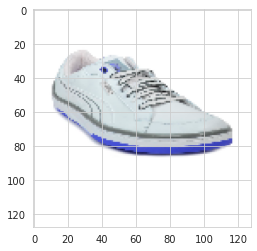

In [36]:
# process all images
selected_images= temp#[0:1000]
paths = [file for file in selected_images]
images = [cv2.resize(cv2.imread(file), (128, 128)) for file in selected_images]
images = np.array(np.float32(images).reshape(len(images),images[0].shape[0],images[0].shape[1],images[0].shape[2])/255)
print(images.shape)
plt.imshow(images[10])

In [49]:
# image size
128 * 128 * 3

49152

# 3b. Calculate images embeddings

In [51]:
# Getting embedded data
## embedding
model = tf.keras.applications.MobileNetV2(include_top = False, weights='imagenet', input_shape=(128, 128, 3)) ## Z include_top = True wychodzi nie tak fajnie
predictions = model.predict(images.reshape(-1, 128, 128, 3)) ## representation of image to reduce size
pred_images = predictions.reshape(images.shape[0], -1) ## reshape
pred_images.shape

(2419, 20480)

In [38]:
pd.DataFrame(pred_images[:10])

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.000002,0.000004,0.000019,0.000084,0.000046,0.000048,0.000011,0.000002,0.000002,0.000007,...,0.000021,0.000002,0.000007,0.000009,0.000041,0.000013,0.000009,0.000032,0.000020,0.000354
1,0.000064,0.000077,0.000049,0.000216,0.000131,0.000079,0.000143,0.000017,0.000037,0.000131,...,0.000041,0.000046,0.000064,0.000021,0.000029,0.000013,0.000047,0.000035,0.000082,0.000330
2,0.000011,0.000041,0.000129,0.000609,0.000101,0.000081,0.000128,0.000008,0.000007,0.000111,...,0.000090,0.000103,0.000052,0.000058,0.000783,0.000073,0.000087,0.001523,0.000074,0.000207
3,0.000027,0.000055,0.000066,0.000130,0.000052,0.000025,0.000044,0.000064,0.000170,0.000723,...,0.000157,0.000051,0.000137,0.000140,0.000050,0.000133,0.000070,0.000129,0.000249,0.000523
4,0.000349,0.000457,0.002440,0.003851,0.001091,0.004278,0.000188,0.000025,0.000011,0.000042,...,0.000018,0.000111,0.000203,0.000055,0.000169,0.000228,0.000145,0.000281,0.000150,0.000787
5,0.000019,0.000023,0.000003,0.000028,0.000013,0.000022,0.000005,0.000007,0.000002,0.000005,...,0.000017,0.000015,0.000018,0.000049,0.000012,0.000001,0.000026,0.000016,0.000013,0.000021
6,0.000211,0.000165,0.000027,0.000173,0.000071,0.000310,0.000028,0.000063,0.000117,0.000056,...,0.000101,0.000266,0.000342,0.000235,0.000185,0.000247,0.000303,0.000352,0.000594,0.000076
7,0.000061,0.000105,0.000012,0.000121,0.000024,0.000469,0.000111,0.000044,0.000026,0.000020,...,0.000098,0.000086,0.000061,0.000211,0.000068,0.000024,0.000655,0.000108,0.000057,0.000077
8,0.000245,0.000242,0.000110,0.000533,0.000278,0.001403,0.000622,0.000197,0.000070,0.000089,...,0.000509,0.000128,0.000154,0.000267,0.000110,0.000146,0.000705,0.000263,0.000222,0.000177
9,0.000163,0.000188,0.000140,0.000376,0.000102,0.000786,0.000047,0.000111,0.000023,0.000041,...,0.000096,0.000106,0.000122,0.000139,0.000342,0.000028,0.000572,0.000083,0.000219,0.000155


In [39]:
selected_images[:5]

['notebooks/xai-survey/edrone-images/1b001ede126c677c394024b8f3e80f17_images.jpg',
 'notebooks/xai-survey/edrone-images/63e4f7008a21ad52e8e004ec132987dd_images.jpg',
 'notebooks/xai-survey/edrone-images/Carlton-London-Women-Black-Sandals_820c53e936db176f74c91934004351ab_images.jpg',
 'notebooks/xai-survey/edrone-images/d3065a1272f7f6f77a002f5a640601d4_images.jpg',
 'notebooks/xai-survey/edrone-images/89ecaa554ef5971e55812242be4559fe_images.jpg']

In [52]:
df_image_embeddings = pd.DataFrame(pred_images)
df_image_embeddings['id'] = [id.replace('notebooks/xai-survey/edrone-images/', '') for id in selected_images] # .replace('_images.jpg', '')
# df_image_embeddings.tail()
df_image_embeddings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2419 entries, 0 to 2418
Columns: 20481 entries, 0 to id
dtypes: float32(20480), object(1)
memory usage: 189.0+ MB


In [53]:
# save image embeddings for future reference
_save_pickle(df_image_embeddings, 'df_image_embeddings_big_edrone', 'notebooks/xai-survey/data')

/home/mmozolewski/notebooks/xai-survey/data/df_image_embeddings_big_edrone.pickle


# 3c. Read metadata dataset

In [72]:
df_image_embeddings = _read_pandas_pickle('df_image_embeddings_big_edrone', 'notebooks/xai-survey/data')

# 3d. Reduction of variables sapce with LSA
- contribution 1: helper function for LSA (memory optimisation by chunking data)

In [73]:
# df_image_embeddings = _read_pandas_pickle('df_image_embeddings_edrone', 'data')  # read data back if needed
df_image_embeddings_lsa = get_LSA(df_image_embeddings, 'id', 1300, None)  # contribution 1

explained variance perc = 95.51842212677002%
processing chunk 0 of 3
processing chunk 1 of 3
processing chunk 2 of 3


In [61]:
df_image_embeddings_lsa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2419 entries, 0 to 2418
Columns: 801 entries, 0 to id
dtypes: float32(800), object(1)
memory usage: 7.4+ MB


In [62]:
df_image_embeddings_lsa.tail()

,0,1,2,3,4,5,6,7,8,9,...,791,792,793,794,795,796,797,798,799,id
2414,0.662258,-0.144750,0.116814,-0.095717,0.017924,0.182228,-0.149384,-0.136274,0.073426,0.203377,...,0.009372,-0.005428,0.006277,-0.012155,-0.007236,-0.001777,0.011304,0.022898,0.010527,b7bb5d4b6cff01df7c6b0c26c7df21cd_images.jpg
2415,0.601557,-0.058183,0.273108,-0.069055,-0.018777,0.035175,-0.137062,0.021447,0.057023,-0.052482,...,-0.008060,-0.014523,0.002375,-0.017003,0.007279,-0.000400,-0.004725,-0.006534,-0.004717,c40a47808b4f1f9d993743a572881a5d_images.jpg
2416,0.514366,0.554223,0.047688,0.094803,0.033994,-0.136048,-0.052252,0.019372,-0.087145,0.084913,...,0.016517,-0.006732,-0.011195,0.010141,0.007148,-0.009533,0.011061,0.008344,0.006509,da1b23c46e6c4a1b86686b0fc0914e5a_images.jpg
2417,0.659578,-0.235380,-0.385111,0.022015,0.020574,0.107910,0.117361,0.026723,-0.112702,-0.039059,...,-0.000232,0.018778,-0.002081,0.017946,-0.011261,0.014958,0.024781,0.005608,0.000488,f23c4d59eb6ca3cd621c3db690e0c708_images.jpg
2418,0.616965,-0.062302,0.189440,0.062049,-0.166398,0.301637,0.033369,0.017683,0.152456,0.056199,...,0.009609,0.004323,0.010402,-0.005510,0.005103,0.001757,0.020748,0.001171,-0.005817,Carlton-London-Women-Black-Gladiator-Sandals_b...


In [63]:
# save LSA for future reference
_save_pickle(df_image_embeddings_lsa.loc[:, df_image_embeddings_lsa.columns != 'cluster_kmeans'], 'df_image_embeddings_lsa_edrone', 'data')

/home/mmozolewski/data/df_image_embeddings_lsa_edrone.pickle


# All products - later is only for shoes

using 726 observations


/home/mmozolewski/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/mmozolewski/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2419 entries, 0 to 2418
Columns: 20482 entries, 0 to cluster_kmeans
dtypes: float32(20480), float64(1), object(1)
memory usage: 189.0+ MB


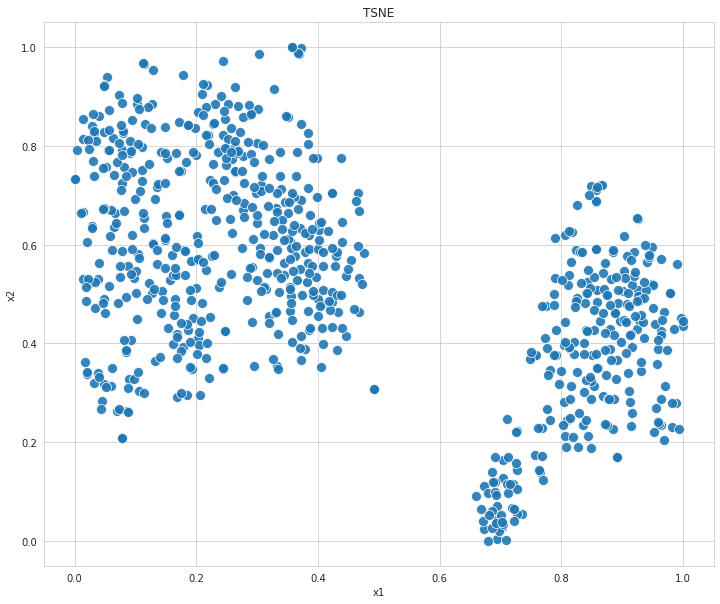

In [74]:
_pipeline = Pipeline(df_image_embeddings, key = 'id')  # contribution 4: plots TSNE on 30% of observations as a hint for number of clusters
_pipeline.df.info()

processing 2 clusters
processing 3 clusters
processing 4 clusters
processing 5 clusters
processing 6 clusters
processing 7 clusters
processing 8 clusters
processing 9 clusters
processing 10 clusters
processing 11 clusters
processing 12 clusters
processing 13 clusters
processing 14 clusters
processing 15 clusters
processing 16 clusters
processing 17 clusters
processing 18 clusters
processing 19 clusters
processing 20 clusters
processing 21 clusters
processing 22 clusters
processing 23 clusters
processing 24 clusters
processing 25 clusters
processing 26 clusters
processing 27 clusters
processing 28 clusters
processing 29 clusters
processing 30 clusters
processing 31 clusters
processing 32 clusters
processing 33 clusters
processing 34 clusters
processing 35 clusters
processing 36 clusters
processing 37 clusters
processing 38 clusters
processing 39 clusters
processing 40 clusters
processing 41 clusters
processing 42 clusters
processing 43 clusters
processing 44 clusters
processing 45 clust

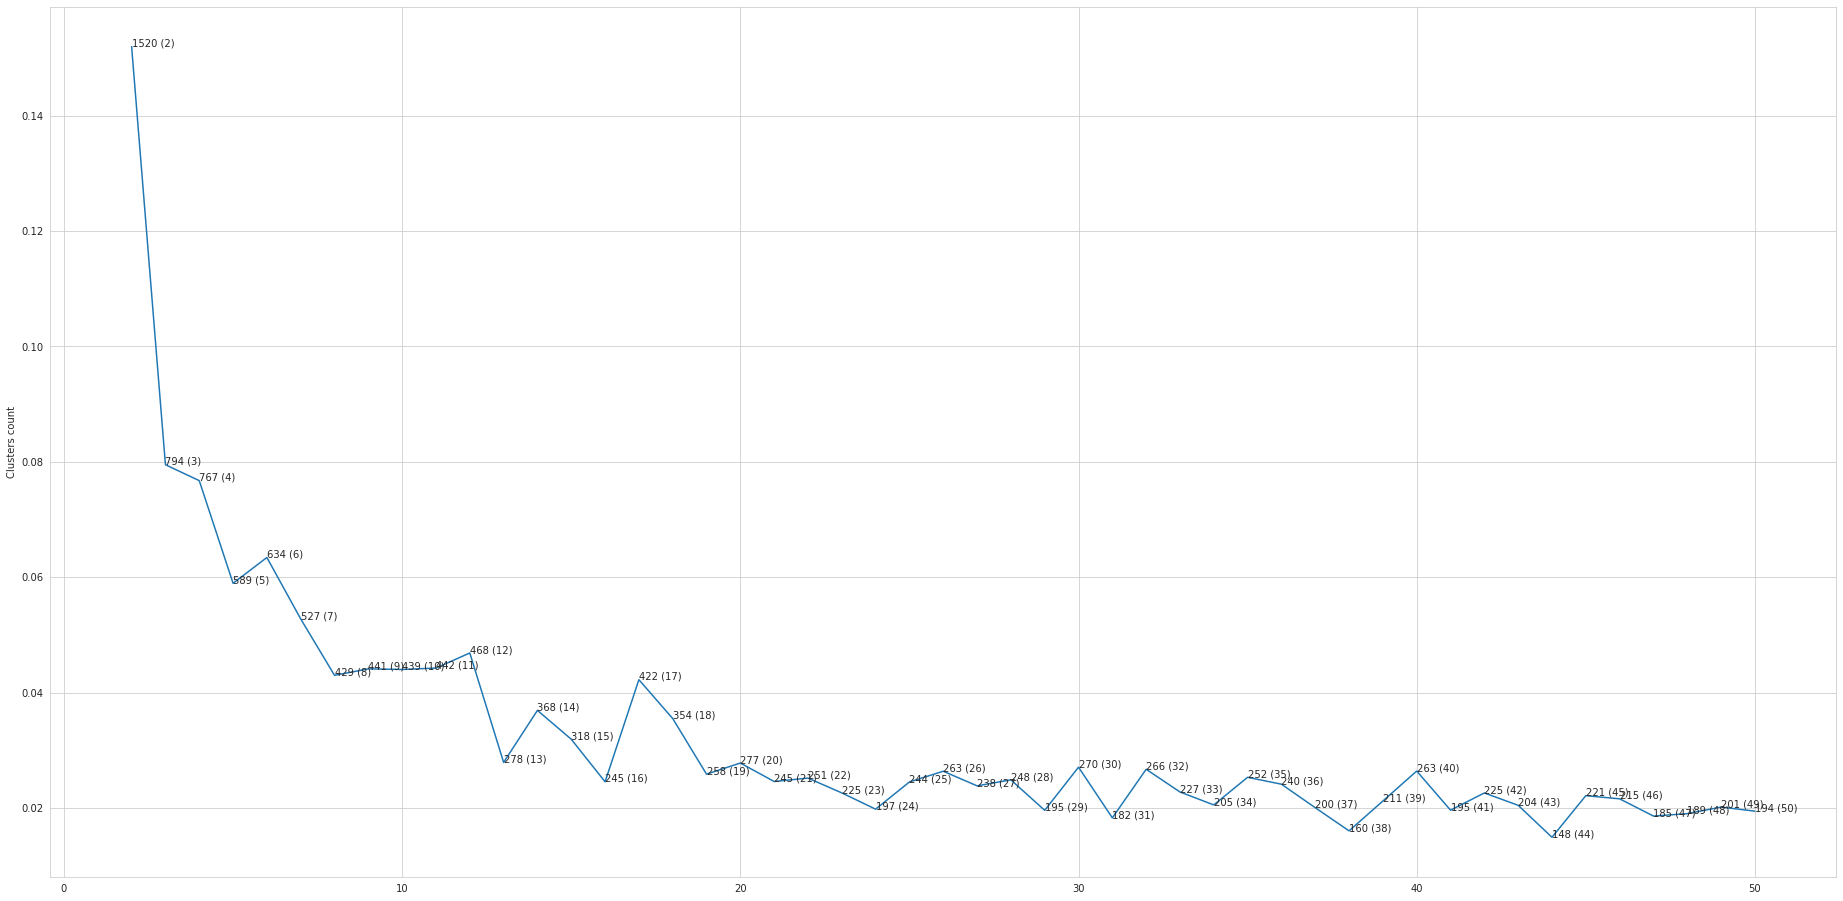

In [75]:
_pipeline.plot_silhouette(50, None, True)

/home/mmozolewski/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/mmozolewski/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


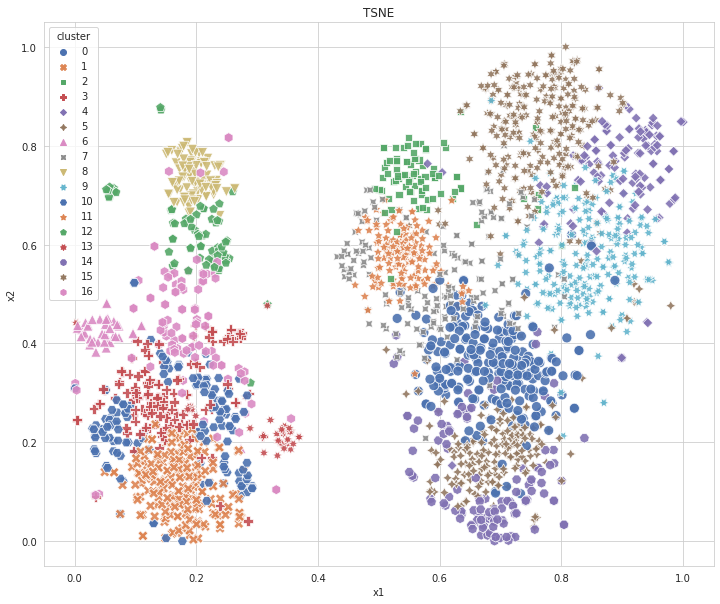

In [76]:
## given silhouette and tsne on this sample:
_pipeline.fit(17)

In [77]:
out_name = "edrone-lsa-17"

_pipeline.df[['id', 'cluster_kmeans']].to_csv(
  f"notebooks/xai-survey/{out_name}.zip",
  index=False,
  compression={"method": "zip", "archive_name": f"{out_name}.csv"},
)

# Only for shoes - this was used

In [81]:
# buty tylko
df_shoe_images = pd.read_csv('~/notebooks/xai-survey/shoes.csv', header=None)

In [104]:
df_shoe_images

,0
0,http://assets.myntassets.com/v1/images/style/p...
1,http://assets.myntassets.com/v1/images/style/p...
2,http://assets.myntassets.com/v1/images/style/p...
3,http://assets.myntassets.com/v1/images/style/p...
4,http://assets.myntassets.com/v1/images/style/p...
...,...
1568,http://assets.myntassets.com/v1/images/style/p...
1569,http://assets.myntassets.com/v1/images/style/p...
1570,http://assets.myntassets.com/v1/images/style/p...
1571,http://assets.myntassets.com/v1/images/style/p...


In [123]:
shoe_images_list =  [x.replace('http://assets.myntassets.com/v1/images/style/properties/', '') for x in df_shoe_images[0].tolist()]
df_image_embeddings_shoes = df_image_embeddings.loc[df_image_embeddings['id'].isin(shoe_images_list)].copy()

In [124]:
df_image_embeddings_shoes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1568 entries, 0 to 2418
Columns: 20482 entries, 0 to cluster_kmeans
dtypes: float32(20480), int64(1), object(1)
memory usage: 122.5+ MB


In [125]:
df_image_embeddings_shoes['id'] = df_image_embeddings_shoes['id'].astype(str)

In [126]:
del df_image_embeddings_shoes['cluster_kmeans']

# 4 Use the same embedings

In [135]:
df_image_embeddings_shoes.reset_index(inplace=True)

In [136]:
del df_image_embeddings_shoes['index']

In [137]:
df_image_embeddings_shoes_lsa = get_LSA(df_image_embeddings_shoes, 'id', 1300, None)

explained variance perc = 98.69155883789062%
processing chunk 0 of 2
processing chunk 1 of 2


In [138]:
df_image_embeddings_shoes_lsa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1568 entries, 0 to 1567
Columns: 1301 entries, 0 to id
dtypes: float32(1300), object(1)
memory usage: 7.8+ MB


In [150]:
df_image_embeddings_shoes_lsa.head()

,0,1,2,3,4,5,6,7,8,9,...,1292,1293,1294,1295,1296,1297,1298,1299,id,cluster_kmeans
0,0.670376,0.281665,-0.114278,-0.144415,-0.072945,-0.021480,-0.021609,0.043696,-0.032782,-0.051744,...,-0.000355,-0.000704,0.002398,0.003168,-0.000443,-0.000631,-0.002629,-0.003958,1b001ede126c677c394024b8f3e80f17_images.jpg,11
1,0.578987,0.231400,0.025935,-0.218294,-0.110540,-0.175257,0.050194,0.053763,-0.031563,0.023031,...,0.001812,-0.001495,-0.002640,-0.000879,0.000820,0.002091,0.000281,-0.000401,Carlton-London-Women-Black-Sandals_820c53e936d...,3
2,0.645472,0.326049,-0.034908,0.050842,-0.138657,0.015532,-0.048087,-0.140740,0.097212,0.196567,...,-0.001829,-0.001117,0.006532,-0.001830,-0.001984,0.000273,-0.006308,-0.001401,89ecaa554ef5971e55812242be4559fe_images.jpg,11
3,0.695346,-0.143647,-0.385259,0.025133,0.108123,0.031194,-0.083087,-0.055573,0.004093,-0.028268,...,-0.002993,0.006514,-0.006812,-0.010784,0.009105,-0.000438,0.000097,0.004910,9c3d77147758ab10f12caf6184fe13ef_images.jpg,15
4,0.679248,0.142826,-0.112627,0.102661,0.314018,0.175878,-0.085410,0.135870,-0.039575,0.081014,...,0.001159,-0.000954,-0.001519,0.016439,0.010882,-0.015536,0.013067,-0.001844,76d6c7b68001277c4f9298b1fd18be47_images.jpg,2


using 470 observations


/home/mmozolewski/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/mmozolewski/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1568 entries, 0 to 1567
Columns: 1302 entries, 0 to cluster_kmeans
dtypes: float32(1300), float64(1), object(1)
memory usage: 7.8+ MB


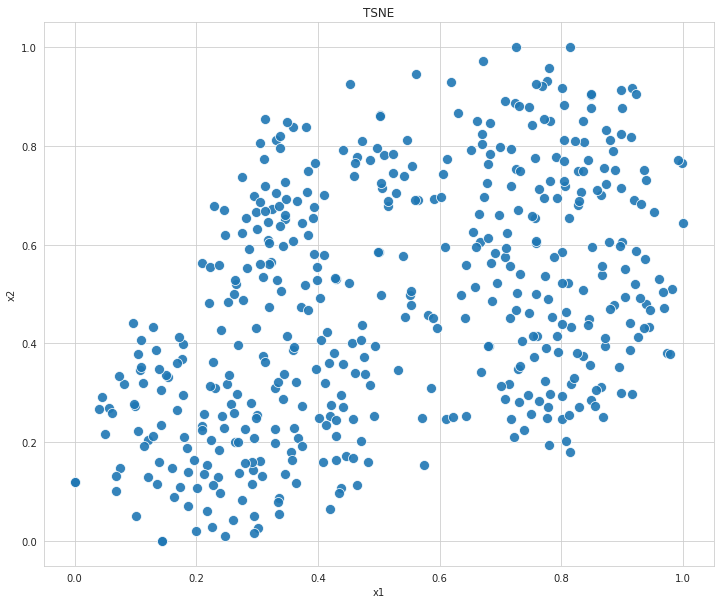

In [140]:
_pipeline_shoes = Pipeline(df_image_embeddings_shoes_lsa, key = 'id')  # contribution 4: plots TSNE on 30% of observations as a hint for number of clusters
_pipeline_shoes.df.info()

# 4b. Plotting Silhouette
- # contribution 4: find optimal number of clusters in k-means

processing 2 clusters
processing 3 clusters
processing 4 clusters
processing 5 clusters
processing 6 clusters
processing 7 clusters
processing 8 clusters
processing 9 clusters
processing 10 clusters
processing 11 clusters
processing 12 clusters
processing 13 clusters
processing 14 clusters
processing 15 clusters
processing 16 clusters
processing 17 clusters
processing 18 clusters
processing 19 clusters
processing 20 clusters
processing 21 clusters
processing 22 clusters
processing 23 clusters
processing 24 clusters
processing 25 clusters
processing 26 clusters
processing 27 clusters
processing 28 clusters
processing 29 clusters
processing 30 clusters
processing 31 clusters
processing 32 clusters
processing 33 clusters
processing 34 clusters
processing 35 clusters
processing 36 clusters
processing 37 clusters
processing 38 clusters
processing 39 clusters
processing 40 clusters
processing 41 clusters
processing 42 clusters
processing 43 clusters
processing 44 clusters
processing 45 clust

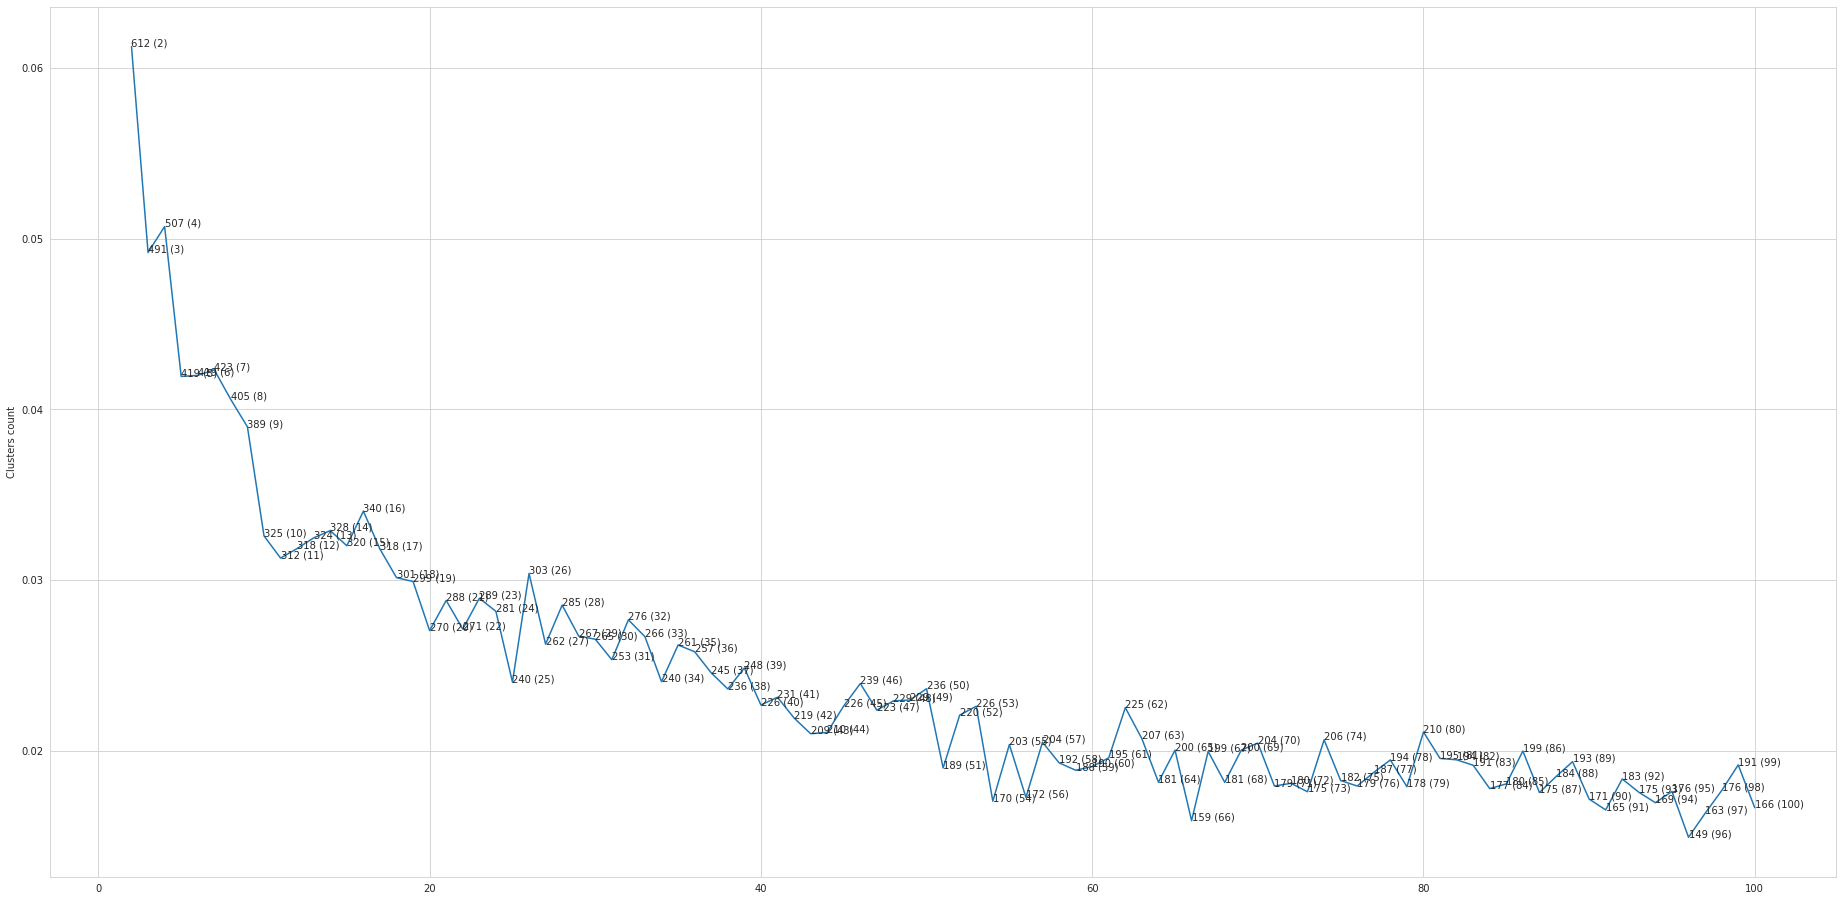

In [144]:
_pipeline_shoes.plot_silhouette(100, None, True)

/home/mmozolewski/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/mmozolewski/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


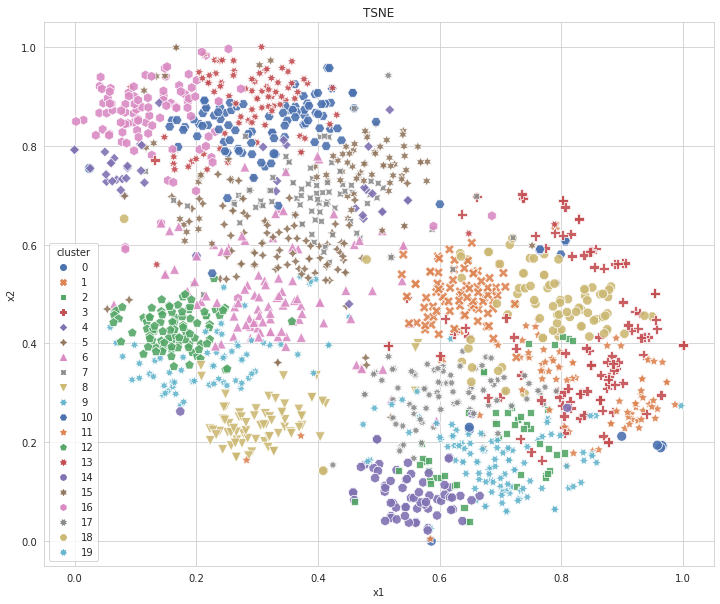

In [147]:
_pipeline_shoes.fit(20)

In [148]:
out_name = "edrone-shoes-lsa-20"

_pipeline_shoes.df[['id', 'cluster_kmeans']].to_csv(
  f"notebooks/xai-survey/{out_name}.zip",
  index=False,
  compression={"method": "zip", "archive_name": f"{out_name}.csv"},
)